In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

## merge brightfield and dapi fluorescent images

In [341]:
# data processing of folder 20230621_DAPI
# separately save frames in a .tif image

if False:
    fdn = '/home/yike/phd/cancer_cells_img_seq/data/experiments/202306/20230621_DAPI/'

    from PIL import Image, ImageSequence
    fn = 'dish3_M9.tif'
    im = Image.open(fdn + fn)
    ims = ImageSequence.Iterator(im)
    
    ims[0].save(fdn + fn.split('.')[0] + "_bf.tif")
    ims[1].save(fdn + fn.split('.')[0] + "_dapi.tif")

In [297]:
# data processing of folder 20230622_DAPI

if False:
    fdn = '/home/yike/phd/cancer_cells_img_seq/data/experiments/202306/20230622_DAPI/'
    
    # rename
    fns = np.unique([i.split('.')[0] for i in os.listdir(fdn) if '.' in i])
    for fn in fns:
        file = open(fdn + fn + '.txt', 'r')
        name = file.readline()
        name = name[0].lower() + name[1:]
        name = name.replace(' ', '_')
        file.close()

        os.rename(fdn + fn + '.txt', fdn + 'controls/' + name + '.txt')
        os.rename(fdn + fn + '.tif', fdn + name + '.tif')
    
    # separate .tif images into brightfield and dapi versions
    from PIL import Image, ImageSequence
    fns = [i for i in os.listdir(fdn) if '.' in i]
    for fn in fns:
        name = fn.split('.')[0]

        im = Image.open(fdn + fn)
        ims = ImageSequence.Iterator(im)

        ims[0].save(fdn + name + "_bf.tif")
        ims[1].save(fdn + name + "_dapi.tif")

        os.rename(fdn + fn, fdn + 'controls/' + fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

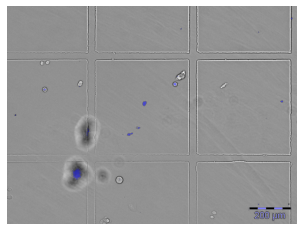

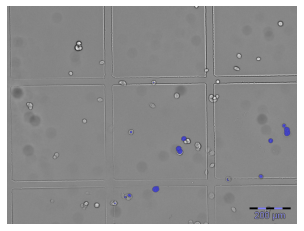

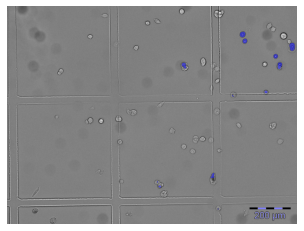

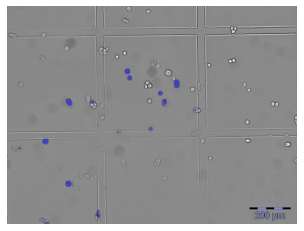

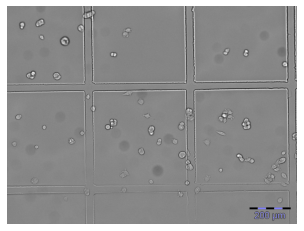

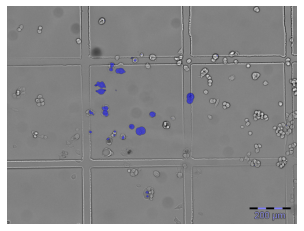

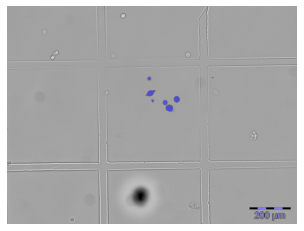

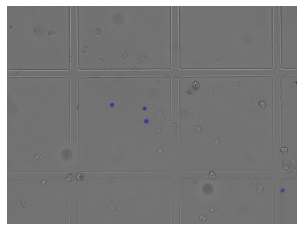

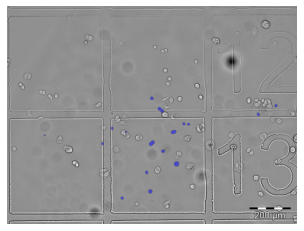

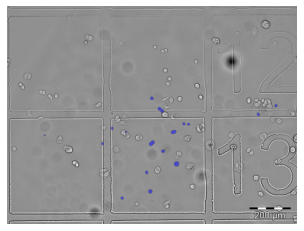

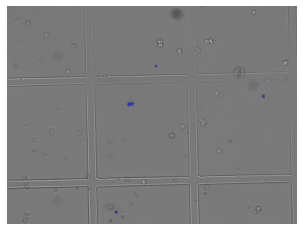

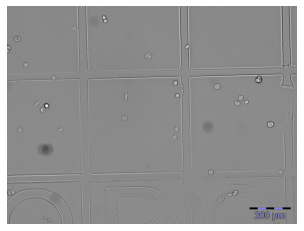

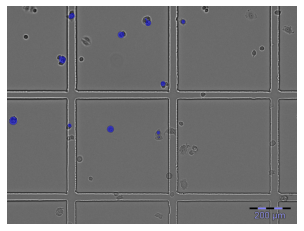

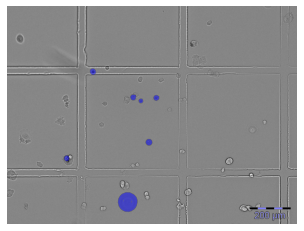

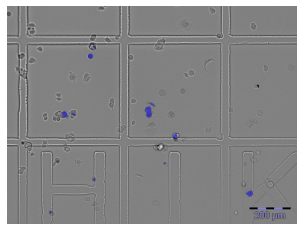

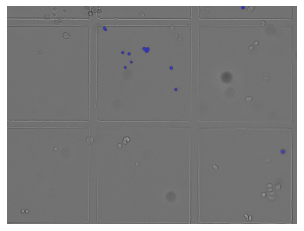

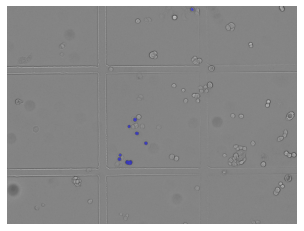

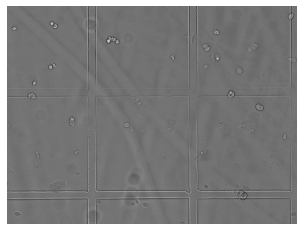

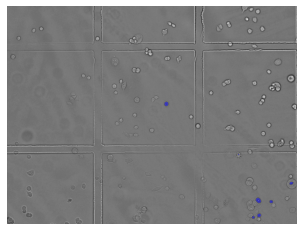

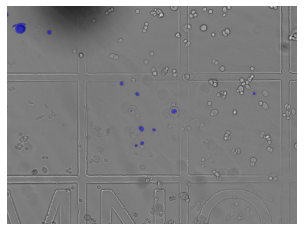

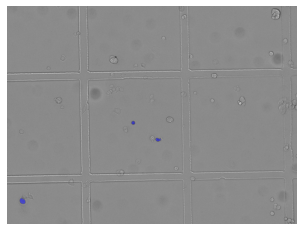

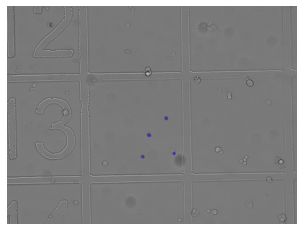

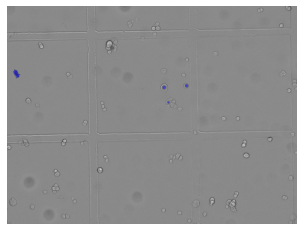

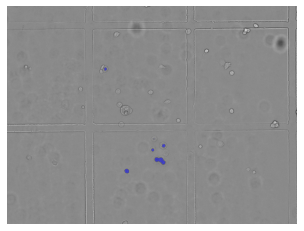

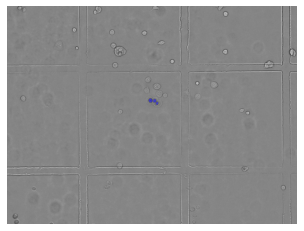

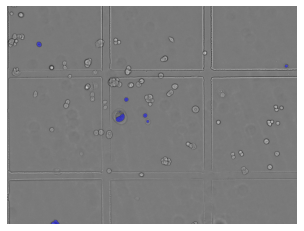

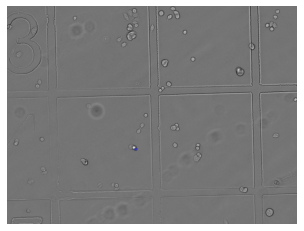

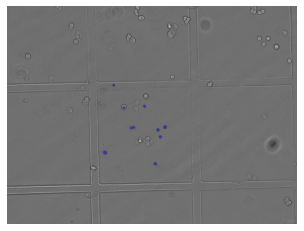

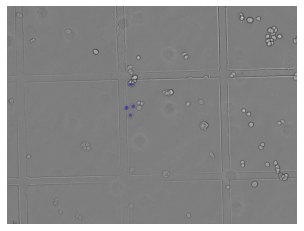

In [446]:
# merge brightfield and dapi fluorescent images
fdn = '/home/yike/phd/cancer_cells_img_seq/data/experiments/202306/'

sub_fdns = ['20230620_DAPI/', '20230621_DAPI/', '20230622_DAPI/']
vmins = [30, 30, 30]

for sub_fdn, vmin in zip(sub_fdns, vmins):
    grids = np.unique([i.split('_')[0] + '_' + i.split('_')[1] for i in os.listdir(fdn + sub_fdn) if '.' in i])
    
    for grid in grids:
        dapi = cv2.imread(fdn + sub_fdn + grid + '_dapi.tif').astype('uint8')
        bf = cv2.imread(fdn + sub_fdn + grid + '_bf.tif').astype('uint8')
        bf_nor = ((bf - bf.min())/ (bf.max() - bf.min()) * 255).astype('uint8') # normalize

        # plot
        fig, ax = plt.subplots()
        ax.imshow(bf_nor)

        mask_o = (dapi[:, :, 0] > vmin) # threshold vmin
        mask = np.zeros(list(mask_o.shape) + [4])
        mask[:, :, 2] = dapi[:, :, 0] * mask_o
        mask[:, :, 3][mask_o] = 0.5

        ax.imshow(mask)
        ax.axis('off')

        name = sub_fdn.split('_')[0] + grid[:1].upper() + grid[1:]
        fig.savefig('/home/yike/phd/cancer_cells_img_seq/figures/batch_202306/merge_dapi_bf/' + name + '.png', 
                    bbox_inches='tight', dpi=150)

In [317]:
## normalize image
# th, dst = cv2.threshold(img, 100, 255, cv2.THRESH_TRUNC) 
# All values above the threshold (100) are set to 127
# All values less than or equal to 127 are unchanged
# The  maxValue is ignored

# th, dst = cv2.threshold(img, 100, 255, cv2.THRESH_TOZERO_INV)
# The numbers below the threshold retain their grayscale value
# The numbers above the threshold are 0, except for the boundary

## crop DAPI bright single cells

In [2]:
def cell_labels(seg_fn):
    # label roughly segmented cells by ilastik according to their size
    print('import segmentated figure')
    seg = cv2.imread(seg_fn, 2)

    print('get labels of each cell')
    from scipy import ndimage as ndi
    seg = ndi.binary_fill_holes(seg - 1)

    labeled, _ = ndi.label(seg)
    return seg, labeled

def save_data(img, wls, cell, seg, labeled, n_ls, save_path):
    img_data = {}

    raw = seg.copy()
    px = [np.bincount(labeled.ravel()).argsort()[::-1][int(i)] for i in n_ls]
    raw[ ~ np.isin(labeled, px)] = 2
    cell_seg = raw == 1
    img_data['segmentation'] = cell_seg
    
    img = img.astype(np.uint16)
    for i, wl in enumerate(wls):
        img_data['wls_{}_{}'.format(str(wl[0]), str(wl[1]))] = img[i].T

    np.savez_compressed(save_path + cell + '.npz', **img_data)

In [3]:
df = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/figures/batch_202306/merge_dapi_bf/dapi_cell_annotation.tsv', 
          sep='\t')
df['Mask'] = df['Batch'].astype(str) + df['Grid'] + '_' + df['Cell_annotation'].astype(str)

figure_npz_fdn = '/home/yike/phd/cancer_cells_img_seq/data/202306_imaging/'
ilastik_seg = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202306/fake_RGB_images/'
cropped_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202306/dapi_cropped_cell_npz/'
sig_cell_images = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202306/dapi_cell_images/'
sig_seg_images = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202306/dapi_cell_segmented_images/'

In [6]:
sig_df = df.copy()
ncells = sig_df.shape[0]

i = 0
picked_fns = os.listdir(ilastik_seg + 'picked_figures/')
unpicked_fns = os.listdir(ilastik_seg + 'unpicked_figures/')

for mask in sig_df['Mask'].unique():
    grid = mask.split('_')[0] + '_' + mask.split('_')[1]
    print('loading...')
    raw = np.load(figure_npz_fdn + grid[:8] + '_imaging/' + grid[8:] + '.npz')
    _, labeled = cell_labels(os.path.join(
        ilastik_seg + ['unpicked_figures/', 'picked_figures/'][grid + '_Simple Segmentation.tiff' in picked_fns], 
        grid + '_Simple Segmentation.tiff'))
    pxs = np.bincount(labeled.ravel()).argsort()[::-1]
    
    margin_px = 80
    for _, row in sig_df[sig_df['Mask'] == mask].iterrows():
        cell = row['Mask']
        antt = int(row['Cell_annotation'])
        print(f'{cell}: {i+1}/{ncells}')
        
        print('find ROI...')
        seg = (labeled == pxs[antt])
        
        i0s = seg.any(axis=1).nonzero()[0]
        i1s = seg.any(axis=0).nonzero()[0]
        i00, i01 = i0s[0], i0s[-1] + 1
        i10, i11 = i1s[0], i1s[-1] + 1

        print('add margins...')
        i00 = max(0, i00 - margin_px)
        i10 = max(0, i10 - margin_px)
        i01 = min(seg.shape[0], i01 + margin_px)
        i11 = min(seg.shape[1], i11 + margin_px)

        print('crop...')
        img_dict = {}
        for key, val in raw.items():
            img_dict[key] = val[i00: i01, i10: i11]
        
        img_dict['segmentation'] = seg[i00: i01, i10: i11]

        print('save to file...')
        np.savez_compressed(os.path.join(cropped_fdn, cell + '.npz'), **img_dict)

        print('done')

loading...
import segmentated figure
get labels of each cell
20230620Dish1_H7_1: 1/42
find ROI...
add margins...
crop...
save to file...
done
loading...
import segmentated figure
get labels of each cell
20230620Dish1_H7_2: 1/42
find ROI...
add margins...
crop...
save to file...
done
loading...
import segmentated figure
get labels of each cell
20230620Dish1_H7_3: 1/42
find ROI...
add margins...
crop...
save to file...
done
loading...
import segmentated figure
get labels of each cell
20230620Dish4_K13_4: 1/42
find ROI...
add margins...
crop...
save to file...
done
loading...
import segmentated figure
get labels of each cell
20230620Dish4_K13_5: 1/42
find ROI...
add margins...
crop...
save to file...
done
loading...
import segmentated figure
get labels of each cell
20230620Dish4_K13_6: 1/42
find ROI...
add margins...
crop...
save to file...
done
loading...
import segmentated figure
get labels of each cell
20230620Dish4_K13_7: 1/42
find ROI...
add margins...
crop...
save to file...
done
lo

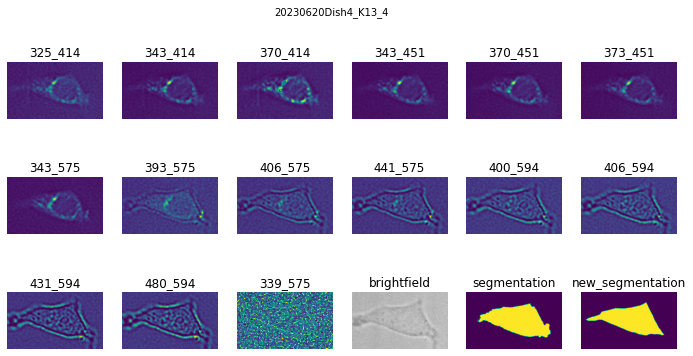

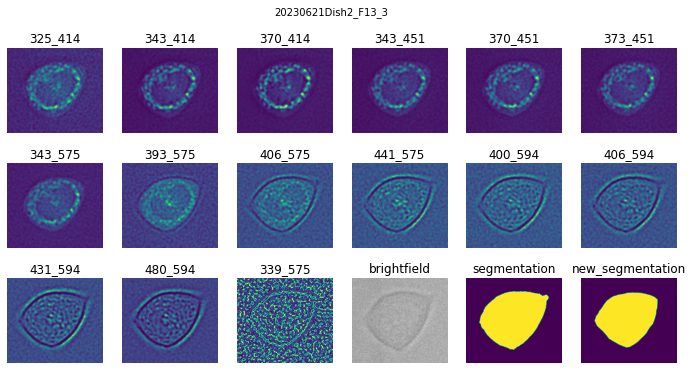

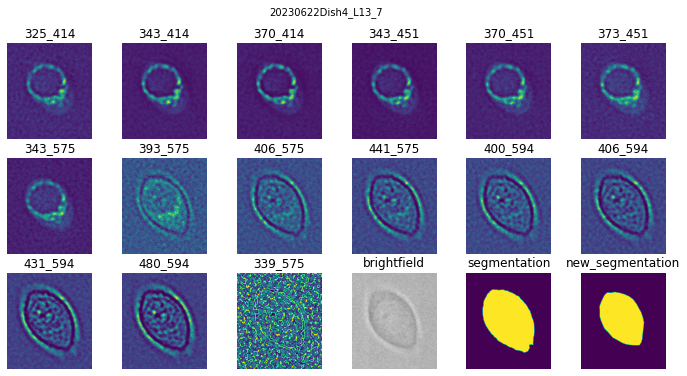

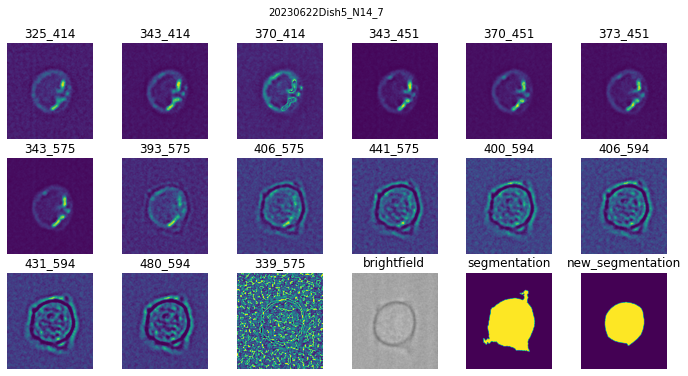

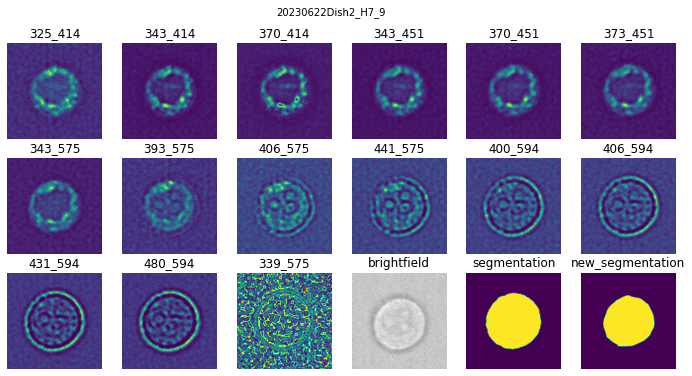

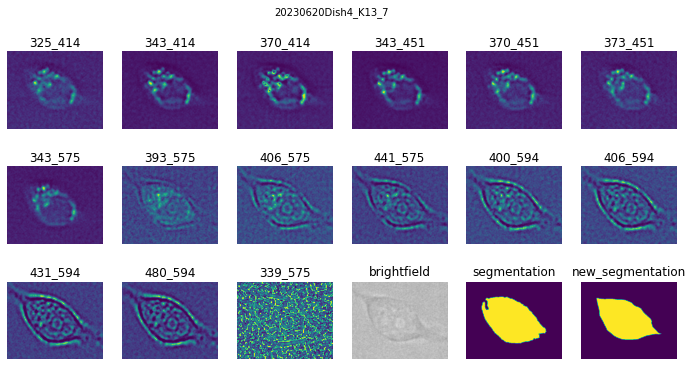

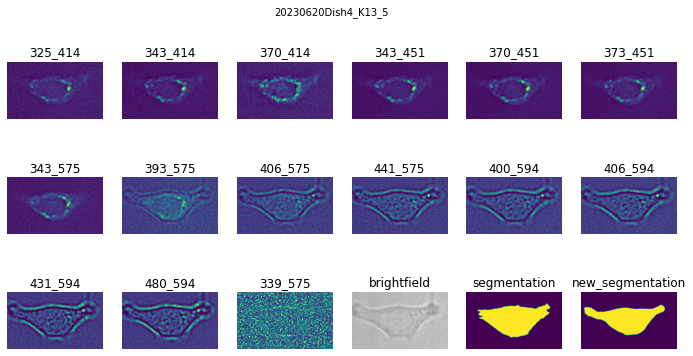

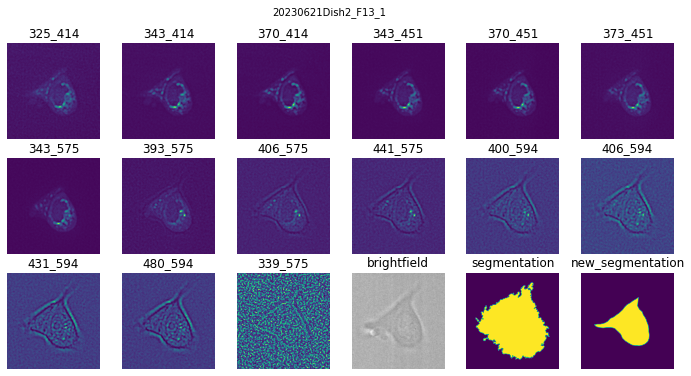

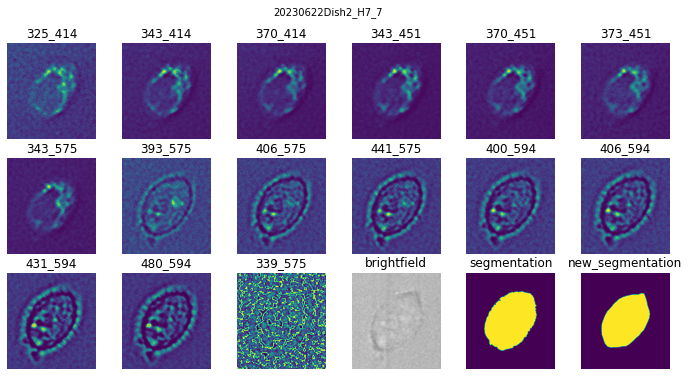

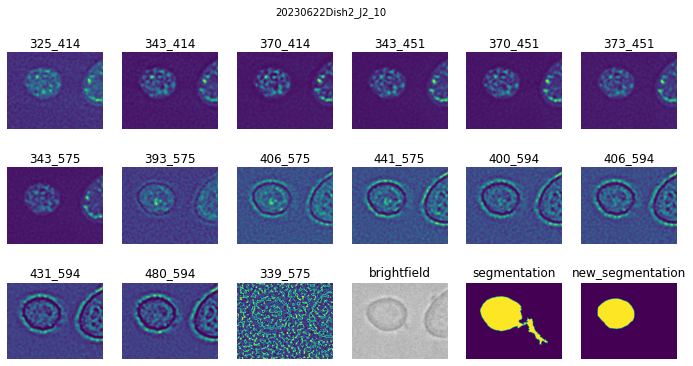

In [18]:
sig_cell_images = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202306/dapi_cell_images'

for fn in [i for i in os.listdir(cropped_fdn) if '.npz' in i]:
    img_dict = np.load(os.path.join(cropped_fdn, fn))
    cell = fn.split('.')[0]
    
    fig, axs = plt.subplots(3, 6, figsize=[12, 6], sharex=True, sharey=True)
    axs = axs.ravel()

    for i, key in enumerate(img_dict.files):
        axs[i].imshow(img_dict[key])
        axs[i].axis('off')
        axs[i].set_title((key, key[4:])['wls' in key])
    
    fig.text(0.5, 0.95, cell, va='center', ha='center')
    
    fig.savefig(os.path.join(sig_cell_images, cell + '.png'), dpi=100, bbox_inches='tight')

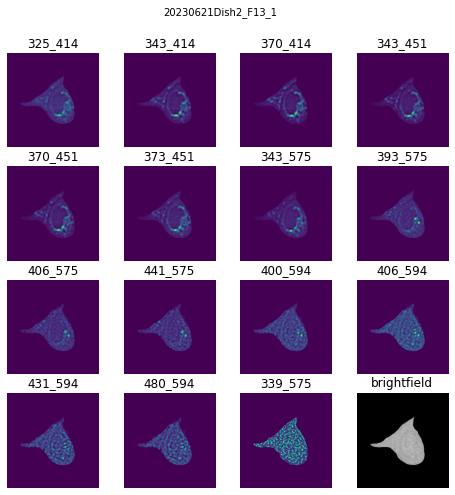

In [16]:
sig_seg_images = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202306/dapi_cell_segmented_images'

for fn in [i for i in os.listdir(cropped_fdn) if '.npz' in i]:

    img_dict = np.load(os.path.join(cropped_fdn, fn))
    cell = fn.split('.')[0]
    
    fig, axs = plt.subplots(4, 4, figsize=[8, 8], sharex=True, sharey=True)
    axs = axs.ravel()

    for i, key in enumerate(img_dict.files[:16]):
        if i < 15:
            axs[i].imshow(img_dict[key] * img_dict['new_segmentation'])
        else:
            reshape = img_dict['new_segmentation'].reshape(img_dict[key].shape[0], img_dict[key].shape[1], 1)
            axs[i].imshow(img_dict[key] * reshape)
            
        axs[i].axis('off')    
        axs[i].set_title((key, key[4:])['wls' in key])
    
    fig.text(0.5, 0.95, cell, va='center', ha='center')
    
    fig.savefig(os.path.join(sig_seg_images , cell + '.png'), dpi=100, bbox_inches='tight')